<a href="https://colab.research.google.com/github/mking2014/final-4449-king/blob/main/make_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook Overview
Notebook goes through overall EDA and imports best models to be used for predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/comp4449_final/data/age_gender.csv')
df = df.drop(columns = ['img_name'])
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (23705, 4)


,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
# Converting pixels into numpy array
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

#EDA

Text(0, 0.5, 'Count')

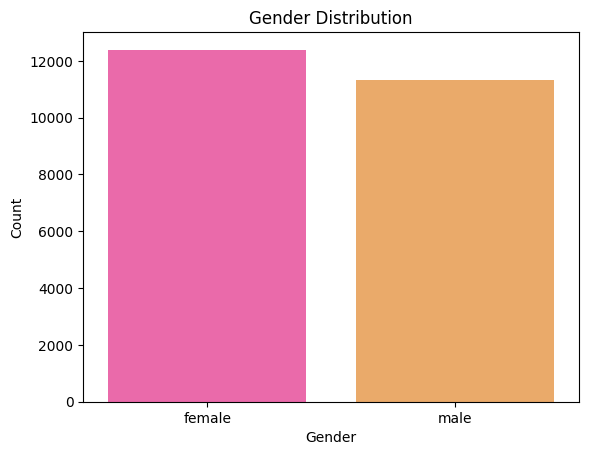

In [5]:
sns.countplot(x="gender", palette='spring', data=df.replace({"gender" : {1 : "male", 0 : "female"}}))
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

In [6]:
df['gender'].value_counts()

0    12391
1    11314
Name: gender, dtype: int64

Text(0, 0.5, 'Count')

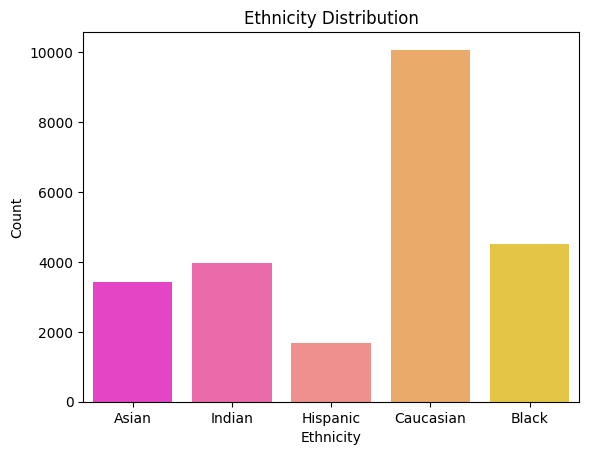

In [7]:
sns.countplot(x="ethnicity", palette='spring',
              data=df.replace({"ethnicity" : {0: "Caucasian", 1: "Black", 2: "Asian", 3:"Indian", 4:"Hispanic"}}))

plt.title('Ethnicity Distribution')
plt.xlabel('Ethnicity')
plt.ylabel('Count')

Text(0.5, 0, 'Age')

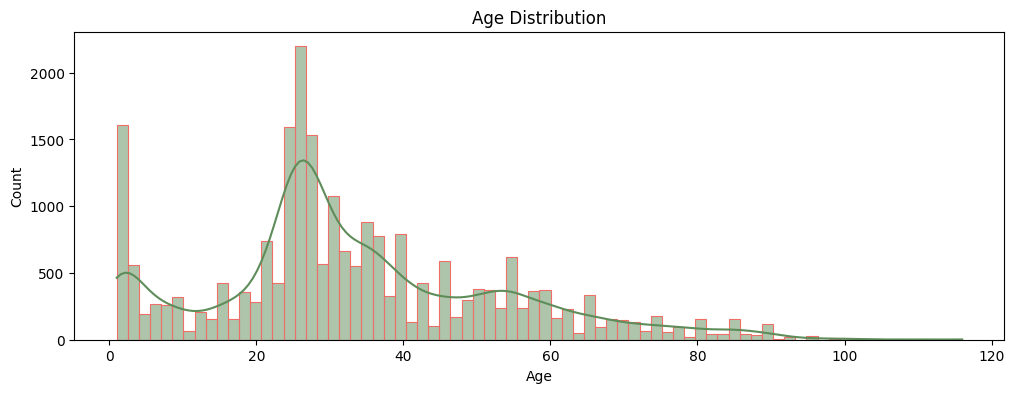

In [8]:
plt.figure(figsize=(12, 4))

sns.histplot(data = df, x='age', color = '#5e8d5a', edgecolor='#ee6f68', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')

In [9]:
df['age'].mean()

33.30090698164944

<Axes: xlabel='age_bin', ylabel='count'>

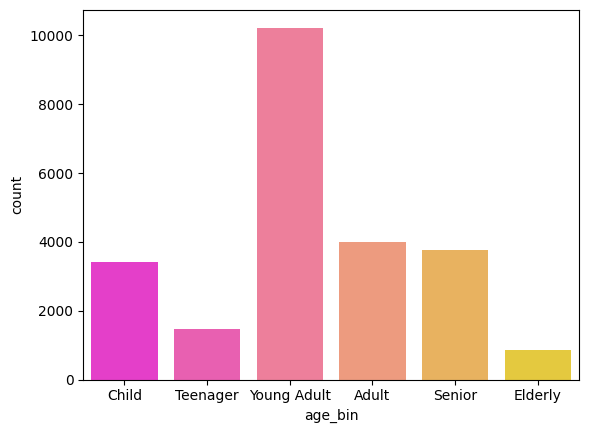

In [10]:
bins = [0, 12, 20, 35, 50, 75, 116]
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior', 'Elderly']
df['age_bin'] = pd.cut(x = df['age'], bins = bins, labels = labels, include_lowest = True)
df['age_bin'].value_counts()

sns.countplot(data = df, x = 'age_bin', palette = 'spring')

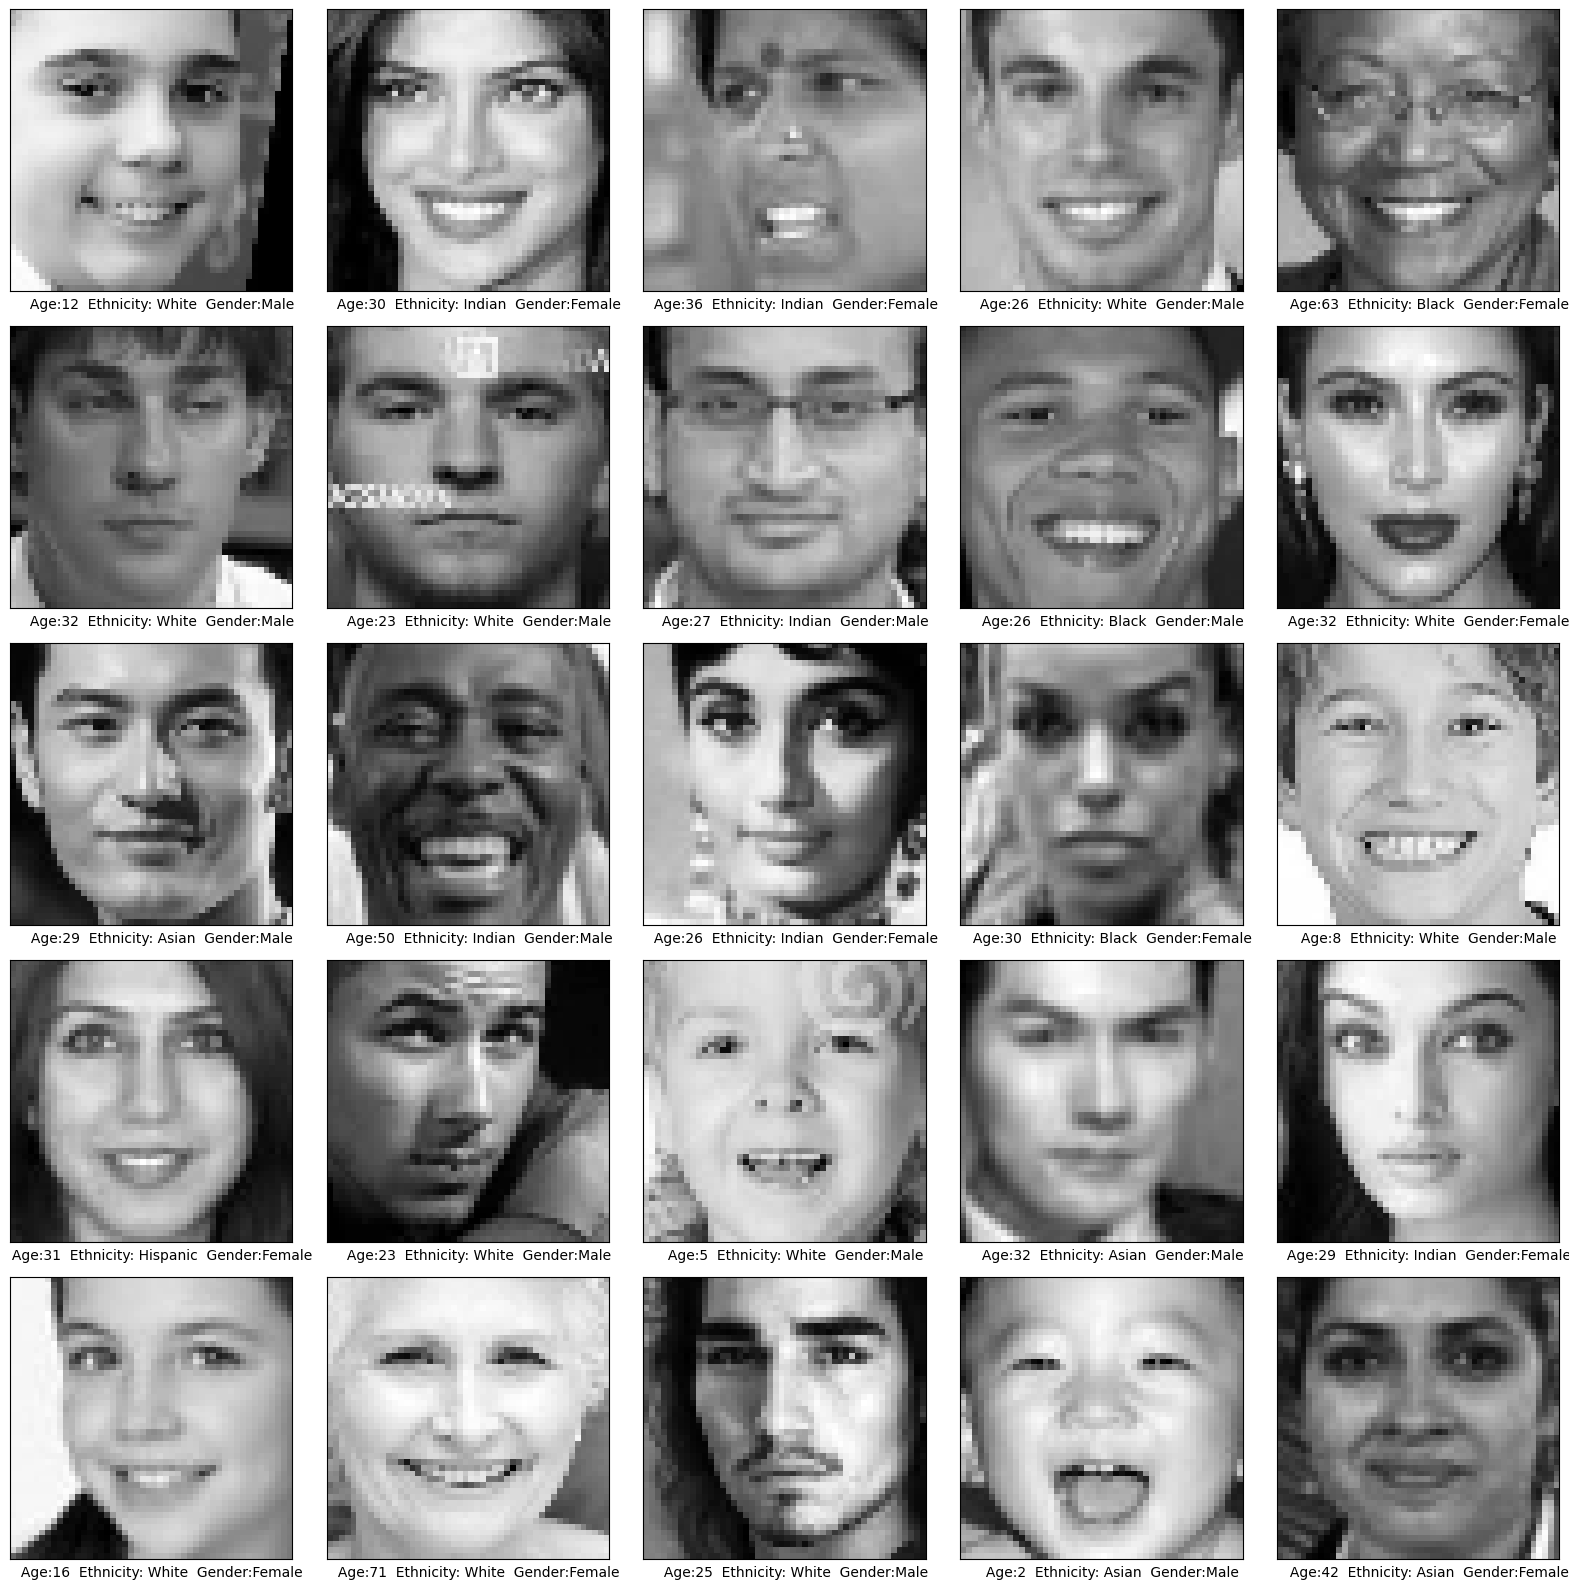

In [11]:
ethnicity_list = ["White", "Black", "Asian", "Indian", "Hispanic"]
gender_list = ['Male', 'Female']

plt.figure(figsize=(16,16))

for i,a in zip(np.random.randint(0, 23705, 25),range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48, 48), cmap ='gray')
    plt.xlabel(
        "     Age:"+str(df['age'].iloc[i])+
        "  Ethnicity: "+ str(ethnicity_list[df['ethnicity'].iloc[i]])+
        "  Gender:"+ str(gender_list[df['gender'].iloc[i]])
    )

plt.tight_layout()
plt.show()

# Data Preparation

In [12]:
# create label encoding for binning ages
encoder = LabelEncoder()
df['ages_encoded'] = encoder.fit_transform(df['age_bin'])
df.head()

age_mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_ ))
age_mapping

{0: 'Adult',
 1: 'Child',
 2: 'Elderly',
 3: 'Senior',
 4: 'Teenager',
 5: 'Young Adult'}

In [13]:
test, train = train_test_split(df, test_size=0.85, random_state=42)
print(train.shape)
print(test.shape)

(20150, 6)
(3555, 6)


In [14]:
#Reshaping images in training & test datasets

X_train = train['pixels']
# normalizing pixels data
X_train = X_train/255.0

# reshape images
X_train = np.array(X_train.tolist())
X_train = X_train.reshape(-1,48,48, 1)
print(f"Shape of training images: {X_train.shape}")

X_test = test['pixels']
# normalizing pixels data
X_test = X_test/255.0

# reshape images
X_test = np.array(X_test.tolist())
X_test = X_test.reshape(-1,48,48, 1)
print(f"Shape of images: {X_test.shape}")

Shape of training images: (20150, 48, 48, 1)
Shape of images: (3555, 48, 48, 1)


In [15]:
# create y training datasets for age regression model

y_train_age = train['age']
y_train_gender = train['gender']
print(f"Age array shape: {(y_train_age.shape)}")
print(f"Gender array shape: {(y_train_gender.shape)}")

y_test_age = test['age']
y_test_gender = test['gender']
print(f"Age array shape: {(y_test_age.shape)}")
print(f"Gender array shape: {(y_test_gender.shape)}")

Age array shape: (20150,)
Gender array shape: (20150,)
Age array shape: (3555,)
Gender array shape: (3555,)


In [16]:
# create y training datasets for age binning model
y_train_age_binned = train['ages_encoded']
print(f"Age array shape: {(y_train_age_binned.shape)}")

y_test_age_binned = test['ages_encoded']
print(f"Age array shape: {(y_test_age_binned.shape)}")

Age array shape: (20150,)
Age array shape: (3555,)


# Load Best Models

In [17]:
gender_model = tf.keras.saving.load_model('/content/drive/MyDrive/comp4449_final/models/gender/3')

In [18]:
age_model = tf.keras.saving.load_model('/content/drive/MyDrive/comp4449_final/models/age/5')

# Predict from models

In [19]:
def predict_age(age, label, img):
  print(f"Actual age: {age}")
  print(f"Actual age group: {label}")

  m_prediction = age_model.predict(img.reshape(-1,48,48, 1), verbose = 0)

  print(f"Predicted age group: {age_mapping[np.argmax(m_prediction, axis = 1)[0]]}")

  return

def predict_gender(label, img):
  gender_map = {0 : "Male", 1 : "Female"}

  print(f"Actual gender: {gender_map[label]}")

  m_prediction = gender_model.predict(img.reshape(-1,48,48, 1), verbose = 0)
  if m_prediction <0.5:
    print(f'Predicted gender: {gender_map[0]}')
  else:
    print(f'Predicted gender: {gender_map[1]}')

  # print(f"Predicted gender: {gender_map[np.argmax(m_prediction, axis = 1)[0]]}")

  return

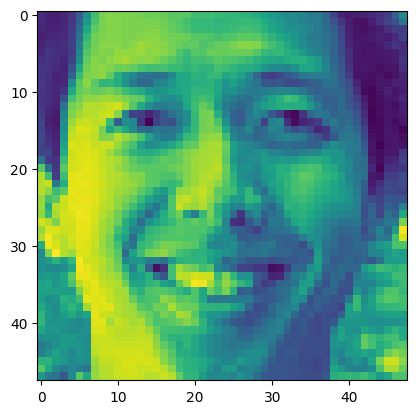

In [51]:
plt.imshow(np.array(test['pixels'].loc[int(pred.index.values)]).reshape(48, 48))

Int64Index([19769], dtype='int64')
<class 'pandas.core.frame.DataFrame'>

here3555
Actual age: 56
Actual age group: Senior
Predicted age group: Teenager

Actual gender: Female
Predicted gender: Female


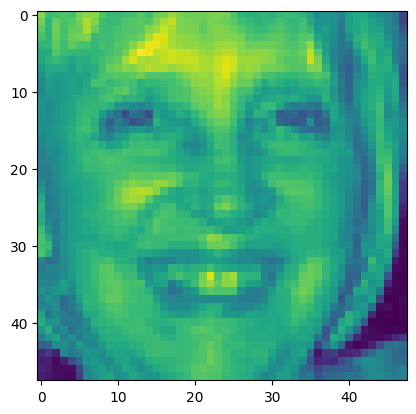

In [53]:
pred = test.sample()

ethnicity_list = ["White", "Black", "Asian", "Indian", "Hispanic"]
gender_list = ['Male', 'Female']

plt.imshow(np.array(test['pixels'].loc[int(pred.index.values)]).reshape(48, 48))


predict_age(pred.values[0][0], pred.values[0][4], pred.values[0][3])
print()
predict_gender(pred.values[0][2], pred.values[0][3])